# DRAGON relationships analysis

See [Makefile](Makefile) for how the results were generated

In [7]:
# initial imports
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from oaklib import get_adapter

from typing import List, Dict

import yaml
import glob

/Users/cjm/Library/Caches/pypoetry/virtualenvs/gpt-ontology-completion-analysis-LiQZhntW-py3.10/lib/python3.10/site-packages/ndex2/nice_cx_network.py:1894: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if mi.get("consistencyGroup" is not None):


In [124]:
def connect(ont: str) -> pd.DataFrame:
    return get_adapter(f"downloads/{ont}.db")


In [125]:
from linkml_runtime.utils.formatutils import camelcase
from collections import defaultdict
from functools import lru_cache


@lru_cache
def labels2ids(ont: str) -> Dict[str, List[str]]:
    m = defaultdict(list)
    adapter = connect(ont)
    for id, lbl in adapter.labels(list(adapter.entities())):
        if not lbl:
            continue
        lbl = camelcase(lbl)
        m[lbl].append(id)
    return m

cl_map = labels2ids("cl")
len(cl_map)

16012

In [126]:
def revmap(m: Dict[str, List[str]]) -> Dict[str, str]:
    r = {}
    for k, v in m.items():
        for x in v:
            r[x] = k
    return r

In [127]:
from pydantic import BaseModel


class Outcome(BaseModel):
    tp: int = 0
    fp: int = 0
    fn: int = 0
    other: List[str] = []

In [179]:
from oaklib.datamodels.vocabulary import IS_A

def score_rels(expected_rels, predicted_rels, ont, strict=False) -> Outcome:
    outcome = Outcome()
    labelmap = labels2ids(ont)
    idmap = revmap(labelmap)
    adapter = get_adapter(f"sqlite:obo:{ont}")
    all_preds = set(expected_rels.keys()).union(set(predicted_rels.keys()))
    for pred in all_preds:
        if pred.lower() == 'subclassof':
            preds = [IS_A]
        else:
            pred_ids = labelmap.get(pred)
            if not pred_ids:
                pred_ids = [ids[0] for lbl, ids in labelmap.items() if pred.lower() == lbl.lower()]
            if not pred_ids:
                print(f"MISSING: {pred}")
                continue
                preds = [IS_A]
            else:
                preds = [IS_A, *pred_ids]
        preds = list(set(preds))
        def lbl2id(lbl):
            return labelmap.get(lbl, [lbl])
        expected_tgts = {x: lbl2id(x) for x in expected_rels.get(pred, [])}
        predicted_tgts = {x: lbl2id(x) for x in predicted_rels.get(pred, [])}
        #print(f"PRED: {pred} // predicted= {predicted_tgts} // expected= {expected_tgts}")
        predicted_accounted_for = set()
        expected_accounted_for = set()
        for expected_tgt in expected_tgts:
            if expected_tgt in predicted_tgts:
                #print(f"TP: {pred} {expected_tgt}")
                outcome.tp += 1
                predicted_accounted_for.add(expected_tgt)
                expected_accounted_for.add(expected_tgt)
            else:
                ok = False
                for expected_tgt_id in expected_tgts.get(expected_tgt, []):
                    ancs = adapter.ancestors(expected_tgt_id, preds)
                    ancs_as_lbls = [idmap.get(x,x) for x in ancs]
                    more_general_predictions = [x for x in ancs_as_lbls if x in predicted_tgts]
                    if more_general_predictions:
                        #print(f"n/a PREDICTED_IS_MORE_GENERAL: {pred} {expected_tgt} // more_general_preds: {more_general_predictions}")
                        predicted_accounted_for.update(more_general_predictions)
                        expected_accounted_for.add(expected_tgt)
                        if strict:
                           outcome.fn += 1
                        else:
                            outcome.other.append(f"{pred} MoreGeneralThan {more_general_predictions} {expected_tgt}")
                        ok = True
                        break
        for predicted_tgt in predicted_tgts:
            if predicted_tgt in predicted_accounted_for:
                continue
            ok = False
            for predicted_tgt_id in predicted_tgts.get(predicted_tgt, []):
                ancs = adapter.ancestors(predicted_tgt_id, preds)
                ancs_as_lbls = [idmap.get(x, x) for x in ancs]
                more_general_expected = [x for x in ancs_as_lbls if x in expected_tgts]
                if more_general_expected:
                    #print(f"?? PREDICTED_IS_MORE_SPECIFIC: {pred} {expected_tgt} // more_general_expected: {more_general_expected}")
                    expected_accounted_for.update(more_general_expected)
                    if strict:
                        outcome.fp += 1
                    else:
                        outcome.other.append(f"{pred} MoreSpecificThan {predicted_tgt} {more_general_expected}")
                    ok = True
                    break
            if not ok:
                #print(f"FP: {pred} {predicted_tgt}")
                outcome.fp += 1
        for expected_tgt in expected_tgts:
            if expected_tgt in expected_accounted_for:
                continue
            #print(f"FN: {pred} {expected_tgt}")
            outcome.fn += 1
    return outcome
                
outcome = score_rels({"subClassOf": ["Cell"], "PartOf": ["Cerebellum"], "DevelopsFrom": ["StemCell"], "OnlyInTaxon": ["HomoSapiens"]}, {"subClassOf": ["Neuron"], "PartOf": ["Brain", "MadeUp"], "MadeUpRel": ["z", "y"], "OnlyInTaxon": ["HomoSapiens"]}, "cl")
print(outcome) 
assert outcome.tp == 1
assert outcome.fp == 1
assert outcome.fn == 1
assert len(outcome.other) == 2

MISSING: MadeUpRel
tp=1 fp=1 fn=1 other=["subClassOf MoreSpecificThan Neuron ['Cell']", "PartOf MoreGeneralThan ['Brain'] Cerebellum"]


In [180]:
assert score_rels({"subClassOf": ["MadeUp"]}, {}, "cl") == Outcome(tp=0, fp=0, fn=1, other=[])

In [181]:
assert score_rels({}, {}, "cl") == Outcome(tp=0, fp=0, fn=0, other=[])

In [182]:
assert score_rels({"subClassOf": ["Cell"]}, {}, "cl") == Outcome(tp=0, fp=0, fn=1, other=[])

In [183]:
assert score_rels({}, {"subClassOf": ["Cell"]}, "cl") == Outcome(tp=0, fp=1, fn=0, other=[])

In [184]:
assert score_rels({"subClassOf": ["Cell"]}, {"subClassOf": ["Cell"]}, "cl") == Outcome(tp=1, fp=0, fn=0, other=[])

In [185]:
outcome = score_rels({"subClassOf": ["Cell"]}, {"subClassOf": ["Neuron"]}, "cl")
assert outcome.tp == 0
assert outcome.fp == 0
assert outcome.fn == 0
assert len(outcome.other) == 1

In [186]:
outcome = score_rels({"subClassOf": ["Neuron"]}, {"subClassOf": ["Cell"]}, "cl")
assert outcome.tp == 0
assert outcome.fp == 0
assert outcome.fn == 0
assert len(outcome.other) == 1

In [187]:
assert score_rels({"subClassOf": ["Neuron"]}, {"subClassOf": ["StemCell"]}, "cl") == Outcome(tp=0, fp=1, fn=1, other=[])


In [217]:
def parse_relationships(rel_str: str) -> Dict[str, List[str]]:
    if pd.isnull(rel_str):
        return {}
    if not isinstance(rel_str, str):
        print(f"BAD: {rel_str}")
        return {}
    rels = yaml.safe_load(rel_str)
    m = defaultdict(list)
    for rel in rels:
        if "predicate" not in rel or "target" not in rel:
            print(f"BAD REL: {rel} in {rel_str}")
            continue
        if not isinstance(rel["target"], str):
            print(f"BAD REL: {rel} in {rel_str}")
            continue
        m[rel["predicate"]].append(rel["target"])
    return m

In [222]:
def load_relationships_results_tsv(f: str, ont: str, preds: List=None, strict=False):
    #adapter = get_adapter(f"sqlite:obo:{ont}")
    res = pd.read_csv(f, comment="#", sep="\t")
    rows = []
    for _, row in res.iterrows():
        expected_rels = parse_relationships(row['expected_relationships'])
        predicted_rels = parse_relationships(row['predicted_relationships'])
        if preds:
            expected_rels = {k: v for k, v in expected_rels.items() if k in preds}
            predicted_rels = {k: v for k, v in predicted_rels.items() if k in preds}
        #print(f"Scoring: {expected_rels} // {predicted_rels}")
        outcome = score_rels(expected_rels, predicted_rels, ont, strict=strict)
        if outcome.other:
            print(f"Other: {outcome}")
        outcome = outcome.model_dump()
        #outcome["expected_relationships"] = json.dumps(expected_rels)
        #outcome["predicted_relationships"] = json.dumps(predicted_rels)
        outcome = {"ontology": ont, 
                   "preds": ",".join(preds) if preds else "all",
                   **outcome, **row.to_dict()}
        rows.append(outcome)
    return rows

rows = load_relationships_results_tsv("results/ont_cl-Prelationships-Mid.original_id-BGFalse-TrNone-Te50-Mgpt-4-EMopenai.results.tsv", "cl", strict=False)
df = pd.DataFrame(rows)
df.to_csv("foo.tsv", sep="\t")
df

MISSING: ReceivesConnectivityInputFrom
MISSING: AxonIn
Other: tp=1 fp=2 fn=2 other=["subClassOf MoreGeneralThan ['Macrophage'] LungMacrophage"]
Other: tp=1 fp=0 fn=1 other=["subClassOf MoreGeneralThan ['SeromucusSecretingCell'] MucusSecretingCellOfTracheobronchialTreeSubmucosalGland"]
MISSING: ConnectsTo
Other: tp=0 fp=1 fn=1 other=["subClassOf MoreGeneralThan ['CiliatedEpithelialCell'] EndometrialCiliatedEpithelialCell"]
Other: tp=0 fp=2 fn=0 other=["subClassOf MoreGeneralThan ['MediumSpinyNeuron'] IndirectPathwayMediumSpinyNeuron"]
MISSING: HasSynapticDivergentTo
MISSING: HasSynapticConvergenceOf
Other: tp=1 fp=0 fn=1 other=["subClassOf MoreGeneralThan ['NeuronAssociatedCell'] GlialCell"]
MISSING: HasCytosolPart
Other: tp=1 fp=0 fn=0 other=["subClassOf MoreGeneralThan ['CiliatedCell', 'EpithelialCell'] CiliatedEpithelialCell"]
Other: tp=0 fp=2 fn=0 other=["subClassOf MoreGeneralThan ['MediumSpinyNeuron'] DirectPathwayMediumSpinyNeuron"]
Other: tp=0 fp=0 fn=0 other=["subClassOf MoreGe

,ontology,preds,tp,fp,fn,other,masked_id,feature_label,feature_definition,feature_aliases,...,predicted_relationships,metric_precision,metric_recall,metric_f1_score,metric_accuracy,metric_specificity,metric_true_positives,metric_true_negatives,metric_false_positives,metric_false_negatives
0,cl,all,1,2,0,[],LungMigratoryDendriticCell,lung migratory dendritic cell,A dendritic cell that captures antigens in a l...,NaN,...,"[{'predicate': 'PartOf', 'target': 'Lung'}, {'...",0.333333,1.000000,0.500000,0.333333,0.0,1,0,2,0
1,cl,all,0,1,1,[],ONBlueConeBipolarCell,ON-blue cone bipolar cell,An ON bipolar cell type with dendrites selecti...,NaN,...,"[{'predicate': 'subClassOf', 'target': 'Photop...",0.000000,0.000000,0.000000,0.000000,0.0,0,0,2,1
2,cl,all,0,2,1,[],DiffuseBipolar3aCell,diffuse bipolar 3a cell,An OFF calbindin-positive bipolar cell that ha...,NaN,...,"[{'predicate': 'subClassOf', 'target': 'OFFCal...",0.000000,0.000000,0.000000,0.000000,0.0,0,0,2,1
3,cl,all,1,2,2,[],EarlySpermatid,early spermatid,A spermatid in an early stage of maturation th...,NaN,...,"[{'predicate': 'subClassOf', 'target': 'Sperma...",0.333333,0.333333,0.333333,0.200000,0.0,1,0,2,2
4,cl,all,1,1,1,[],AirwaySubmucosalGlandDuctBasalCell,airway submucosal gland duct basal cell,A basal cell that is part of a duct of an airw...,NaN,...,"[{'predicate': 'PartOf', 'target': 'DuctOfAirw...",0.500000,0.500000,0.500000,0.333333,0.0,1,0,1,1
5,cl,all,2,0,0,[],PerichondrialFibroblast,perichondrial fibroblast,A fibroblast that is part of the fibrous layer...,NaN,...,"[{'predicate': 'PartOf', 'target': 'OuterFibro...",1.000000,1.000000,1.000000,1.000000,0.0,2,0,0,0
6,cl,all,1,0,0,[],InvaginatingMidgetBipolarCell,invaginating midget bipolar cell,An ON bipolar cell with a small dendritic tree...,NaN,...,"[{'predicate': 'AxonIn', 'target': 'Sublaminar...",0.500000,1.000000,0.666667,0.500000,0.0,1,0,1,0
7,cl,all,1,2,0,[],EccentricMediumSpinyNeuron,eccentric medium spiny neuron,A medium spiny neuron that exhibits transcript...,NaN,...,"[{'predicate': 'HasSomaLocation', 'target': 'B...",0.333333,1.000000,0.500000,0.333333,0.0,1,0,2,0
8,cl,all,2,2,2,[],D1D2HybridMediumSpinyNeuron,D1/D2-hybrid medium spiny neuron,A medium spiny neuron that expresses both DRD1...,NaN,...,"[{'predicate': 'Expresses', 'target': 'D1A_dop...",0.500000,0.500000,0.500000,0.333333,0.0,2,0,2,2
9,cl,all,1,1,0,[],MetallothioneinPositiveAlveolarMacrophage,metallothionein-positive alveolar macrophage,An alveolar macrophage that expresses metallot...,NaN,...,"[{'predicate': 'Expresses', 'target': 'Metallo...",0.500000,1.000000,0.666667,0.500000,0.0,1,0,1,0


In [224]:
rows = load_relationships_results_tsv("results/ont_cl-Prelationships-Mid.original_id-BGFalse-TrNone-Te50-Mgpt-4-EMopenai.results.tsv", "cl", preds=["subClassOf"])
df = pd.DataFrame(rows)
df

Other: tp=0 fp=0 fn=2 other=["subClassOf MoreGeneralThan ['Macrophage'] LungMacrophage"]
Other: tp=0 fp=0 fn=1 other=["subClassOf MoreGeneralThan ['SeromucusSecretingCell'] MucusSecretingCellOfTracheobronchialTreeSubmucosalGland"]
Other: tp=0 fp=0 fn=0 other=["subClassOf MoreGeneralThan ['CiliatedEpithelialCell'] EndometrialCiliatedEpithelialCell"]
Other: tp=0 fp=1 fn=0 other=["subClassOf MoreGeneralThan ['MediumSpinyNeuron'] IndirectPathwayMediumSpinyNeuron"]
Other: tp=0 fp=0 fn=0 other=["subClassOf MoreGeneralThan ['NeuronAssociatedCell'] GlialCell"]
Other: tp=0 fp=0 fn=0 other=["subClassOf MoreGeneralThan ['CiliatedCell', 'EpithelialCell'] CiliatedEpithelialCell"]
Other: tp=0 fp=0 fn=0 other=["subClassOf MoreGeneralThan ['MediumSpinyNeuron'] DirectPathwayMediumSpinyNeuron"]
Other: tp=0 fp=0 fn=0 other=["subClassOf MoreGeneralThan ['SmoothMuscleCell'] TracheobronchialSmoothMuscleCell"]
Other: tp=0 fp=0 fn=0 other=["subClassOf MoreGeneralThan ['MediumSpinyNeuron'] IndirectPathwayMediu

,ontology,preds,tp,fp,fn,other,masked_id,feature_label,feature_definition,feature_aliases,...,predicted_relationships,metric_precision,metric_recall,metric_f1_score,metric_accuracy,metric_specificity,metric_true_positives,metric_true_negatives,metric_false_positives,metric_false_negatives
0,cl,subClassOf,1,0,0,[],LungMigratoryDendriticCell,lung migratory dendritic cell,A dendritic cell that captures antigens in a l...,NaN,...,"[{'predicate': 'PartOf', 'target': 'Lung'}, {'...",0.333333,1.000000,0.500000,0.333333,0.0,1,0,2,0
1,cl,subClassOf,0,1,1,[],ONBlueConeBipolarCell,ON-blue cone bipolar cell,An ON bipolar cell type with dendrites selecti...,NaN,...,"[{'predicate': 'subClassOf', 'target': 'Photop...",0.000000,0.000000,0.000000,0.000000,0.0,0,0,2,1
2,cl,subClassOf,0,2,1,[],DiffuseBipolar3aCell,diffuse bipolar 3a cell,An OFF calbindin-positive bipolar cell that ha...,NaN,...,"[{'predicate': 'subClassOf', 'target': 'OFFCal...",0.000000,0.000000,0.000000,0.000000,0.0,0,0,2,1
3,cl,subClassOf,1,0,0,[],EarlySpermatid,early spermatid,A spermatid in an early stage of maturation th...,NaN,...,"[{'predicate': 'subClassOf', 'target': 'Sperma...",0.333333,0.333333,0.333333,0.200000,0.0,1,0,2,2
4,cl,subClassOf,1,0,0,[],AirwaySubmucosalGlandDuctBasalCell,airway submucosal gland duct basal cell,A basal cell that is part of a duct of an airw...,NaN,...,"[{'predicate': 'PartOf', 'target': 'DuctOfAirw...",0.500000,0.500000,0.500000,0.333333,0.0,1,0,1,1
5,cl,subClassOf,1,0,0,[],PerichondrialFibroblast,perichondrial fibroblast,A fibroblast that is part of the fibrous layer...,NaN,...,"[{'predicate': 'PartOf', 'target': 'OuterFibro...",1.000000,1.000000,1.000000,1.000000,0.0,2,0,0,0
6,cl,subClassOf,1,0,0,[],InvaginatingMidgetBipolarCell,invaginating midget bipolar cell,An ON bipolar cell with a small dendritic tree...,NaN,...,"[{'predicate': 'AxonIn', 'target': 'Sublaminar...",0.500000,1.000000,0.666667,0.500000,0.0,1,0,1,0
7,cl,subClassOf,1,1,0,[],EccentricMediumSpinyNeuron,eccentric medium spiny neuron,A medium spiny neuron that exhibits transcript...,NaN,...,"[{'predicate': 'HasSomaLocation', 'target': 'B...",0.333333,1.000000,0.500000,0.333333,0.0,1,0,2,0
8,cl,subClassOf,1,0,0,[],D1D2HybridMediumSpinyNeuron,D1/D2-hybrid medium spiny neuron,A medium spiny neuron that expresses both DRD1...,NaN,...,"[{'predicate': 'Expresses', 'target': 'D1A_dop...",0.500000,0.500000,0.500000,0.333333,0.0,2,0,2,2
9,cl,subClassOf,1,0,0,[],MetallothioneinPositiveAlveolarMacrophage,metallothionein-positive alveolar macrophage,An alveolar macrophage that expresses metallot...,NaN,...,"[{'predicate': 'Expresses', 'target': 'Metallo...",0.500000,1.000000,0.666667,0.500000,0.0,1,0,1,0


In [235]:
def get_method(obj: dict) -> str:
    """
    gets the method from the yaml object
    """
    if obj.get("generate_background"):
        return "RAG+background"
    additional = obj.get("additional_collections", [])
    if additional:
        assert len(additional) == 1
        x = additional[0]
        if x.startswith("gh_"):
            return "RAG+github"
        elif x.startswith("devdocs"):
            return "RAG+devdocs"
        else:
            assert False
    else:
        return "RAG"

In [236]:
import re

def load_all_results(preds=None):
    files = glob.glob("results/*.results.yaml")
    rows = []
    for f in files:
        obj = yaml.safe_load(open(f))
        if "Prelationships" not in f:
            continue
        # look for string '/ont_{ONT}-Prelationships' using regex
        m = re.search(r"ont_(\w+)-Prelationships", f)
        assert m
        print(f)
        ont = m.group(1)
        this_rows = load_relationships_results_tsv(f.replace(".yaml", ".tsv"), ont, preds, strict=False)
        for row in this_rows:
            row = {**obj, **row}
            row["method"] = get_method(obj)
            rows.append(row)
        #rows.extend(this_rows)
        
    return pd.DataFrame(rows)


In [237]:
df = load_all_results()

results/ont_go-Prelationships-Mid.original_id-BGTrue-TrNone-Te50-Mgpt-4-EMopenai.results.yaml
Other: tp=1 fp=0 fn=0 other=["subClassOf MoreGeneralThan ['Detoxification'] DetoxificationOfInorganicCompound"]
Other: tp=0 fp=1 fn=0 other=["subClassOf MoreGeneralThan ['RetrotransposonSilencing'] RetrotransposonSilencingByMRNADestabilization"]
Other: tp=0 fp=0 fn=0 other=["subClassOf MoreSpecificThan DisruptionOfCellularAnatomicalStructureInAnotherOrganism ['DisruptionOfAnatomicalStructureInAnotherOrganism']"]
MISSING: HasProduct
Other: tp=0 fp=2 fn=2 other=["subClassOf MoreGeneralThan ['OxidoreductaseActivity'] DisulfideOxidoreductaseActivity"]
Other: tp=0 fp=1 fn=0 other=["subClassOf MoreGeneralThan ['CellularProcessInvolvedInReproductionInMulticellularOrganism', 'EpigeneticRegulationOfGeneExpression'] GenomicImprinting"]
Other: tp=0 fp=0 fn=0 other=["subClassOf MoreSpecificThan ProteinTagActivity ['MolecularTagActivity']"]
Other: tp=1 fp=0 fn=0 other=["subClassOf MoreGeneralThan ['Cellula

In [238]:
df.to_csv("results/relationship-analysis.tsv", sep="\t", index=False)

In [239]:
isa_df = load_all_results(["subClassOf"])
isa_df.to_csv("results/relationship-analysis-isa.tsv", sep="\t")

results/ont_go-Prelationships-Mid.original_id-BGTrue-TrNone-Te50-Mgpt-4-EMopenai.results.yaml
Other: tp=0 fp=0 fn=0 other=["subClassOf MoreGeneralThan ['Detoxification'] DetoxificationOfInorganicCompound"]
Other: tp=0 fp=1 fn=0 other=["subClassOf MoreGeneralThan ['RetrotransposonSilencing'] RetrotransposonSilencingByMRNADestabilization"]
Other: tp=0 fp=0 fn=0 other=["subClassOf MoreSpecificThan DisruptionOfCellularAnatomicalStructureInAnotherOrganism ['DisruptionOfAnatomicalStructureInAnotherOrganism']"]
Other: tp=0 fp=0 fn=2 other=["subClassOf MoreGeneralThan ['OxidoreductaseActivity'] DisulfideOxidoreductaseActivity"]
Other: tp=0 fp=0 fn=0 other=["subClassOf MoreGeneralThan ['CellularProcessInvolvedInReproductionInMulticellularOrganism', 'EpigeneticRegulationOfGeneExpression'] GenomicImprinting"]
Other: tp=0 fp=0 fn=0 other=["subClassOf MoreSpecificThan ProteinTagActivity ['MolecularTagActivity']"]
Other: tp=0 fp=0 fn=0 other=["subClassOf MoreGeneralThan ['CellularHomeostasis'] Intra

## Loading YAML result objects

Each run generates a single yaml object

In [49]:


def load_results(f):
    """Loads main results summaries"""
    obj = yaml.safe_load(open(f))
    ont = obj["source_collection"].replace("ont_", "")
    for k, v in obj["results"].items():
        obj[k] = v
    del obj["results"]
    obj["task"] = " ".join(obj["fields_to_predict"])
    obj["ontology"] = ont
    #additional = obj.get("additional_collections", [])
    #is_github = any(x for x in additional if x.startswith("gh_")) if additional else []
    #obj["method"] = "background" if obj.get("generate_background") else ("github" if is_github else "direct")
    obj["method"] = get_method(obj)
    return obj

from pathlib import Path
def load_granular_results():
    files = glob.glob("results/*.results.tsv")
    dfs = []
    for file in files:
        yaml_path = file.replace(".tsv", ".yaml")
        if not Path(yaml_path).exists():
            continue
        meta = yaml.safe_load(open(yaml_path))
        # print(file)
        res = pd.read_csv(file, comment="#", sep="\t")
        #res['task'] = res.apply(lambda row :  " ".join(row.get("fields_to_predict", [])), axis = 1)
        #res['ontology'] = res.apply(lambda row :  row.get("source_collection", "").replace("ont_", ""), axis = 1)
        res['task'] =  " ".join(meta.get("fields_to_predict"))
        res['ontology'] = meta.get("source_collection", "").replace("ont_", "")
        res["method"] = get_method(meta)
        res["model_name"] = meta["model_name"]
        res["accuracy"] = res["metric_accuracy"]
        dfs.append(res)
    return pd.concat(dfs)

all_df = load_granular_results()
all_df.describe(include='all')

,masked_id,expected_label,feature_definition,feature_aliases,feature_relationships,feature_logical_definition,masked_original_id,predicted_label,metric_precision,metric_recall,...,predicted_definition,id,label,definition,aliases,relationships,logical_definition,original_id,expected_logical_definition,predicted_logical_definition
count,7782,2164,4272,0.0,5618,1790,7782,2154,7782.00000,7782.000000,...,2559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,182,474
unique,494,494,436,NaN,426,122,494,1305,NaN,NaN,...,2202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91,308
top,LungMigratoryDendriticCell,lung migratory dendritic cell,A dendritic cell that captures antigens in a l...,NaN,"[{'predicate': 'subClassOf', 'target': 'Functi...","[{'predicate': 'rdfs:subClassOf', 'target': 'F...",CL:4033045,The Thing,NaN,NaN,...,.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'predicate': 'rdfs:subClassOf', 'target': 'F...","[{'predicate': 'rdfs:subClassOf', 'target': 'O..."
freq,20,5,12,NaN,120,18,20,8,NaN,NaN,...,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,9
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.23238,0.237787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.39995,0.405865,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50000,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
import glob

def load_all_results() -> List[dict]:
    """
    load all yaml files
    """
    files = glob.glob("results/*.results.yaml")
    objs = [load_results(f) for f in files]
    return objs

objs = load_all_results()
len(objs)
    

159

In [51]:
df = pd.DataFrame(objs)
df = df.query("model_name != 'llama2'") # incomplete
df.describe(include="all")

,model_name,embedding_model_name,generate_background,task_started,task_finished,executed_on,agent,extractor,method,source_db_path,...,recall,f1_score,accuracy,specificity,true_positives,true_negatives,false_positives,false_negatives,task,ontology
count,159,159,159,159,159,159,159,159,159,159,...,159.000000,159.000000,159.000000,159.0,159.000000,159.0,159.000000,159.000000,159,159
unique,3,1,2,159,159,1,1,1,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,10
top,gpt-3.5-turbo,openai:,False,2023-09-04 13:31:12.160393,2023-09-04 13:32:28.413164,Darwin-21.6.0-Darwin Kernel Version 21.6.0: Mo...,dae,BasicExtractor,RAG,db,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,definition,cl
freq,64,159,115,1,1,159,159,159,105,159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59,20
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.236555,0.229404,0.214694,0.0,15.823899,0.0,43.654088,38.553459,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.198055,0.192455,0.183317,0.0,15.478664,0.0,19.602695,17.011034,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.060000,0.060000,0.060000,0.0,3.000000,0.0,33.000000,29.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.207639,0.189159,0.160000,0.0,13.000000,0.0,42.000000,39.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.380000,0.378095,0.349833,0.0,26.000000,0.0,47.000000,47.000000,NaN,NaN


In [52]:
df.query(f"task=='relationships' and method=='direct' and model_name=='gpt-4'")

,model_name,embedding_model_name,generate_background,task_started,task_finished,executed_on,agent,extractor,method,source_db_path,...,recall,f1_score,accuracy,specificity,true_positives,true_negatives,false_positives,false_negatives,task,ontology


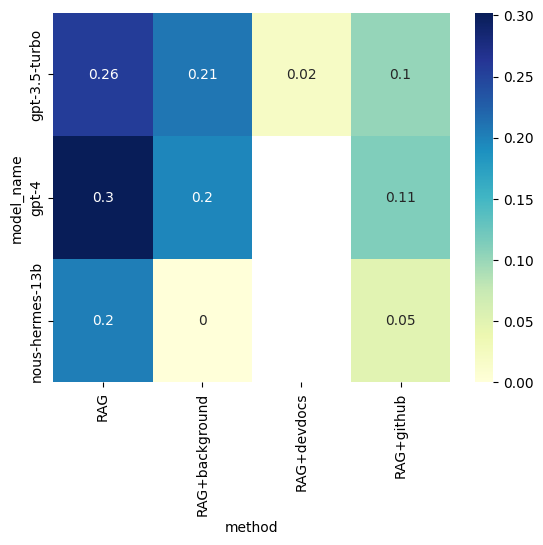

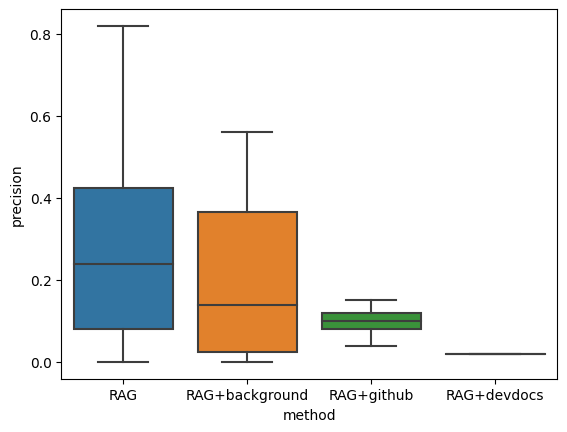

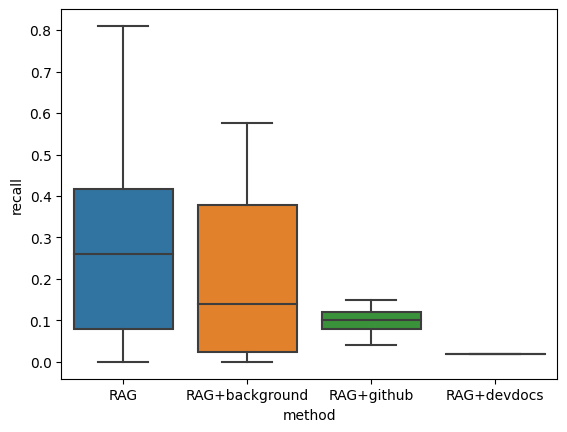

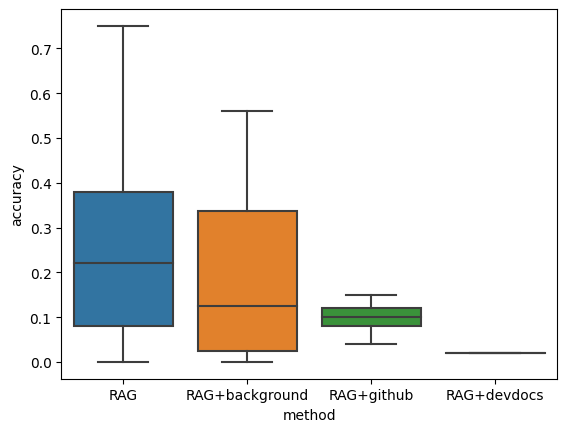

In [54]:

# Line plot for precision across different models and methods
#sns.lineplot(data=df, x='model_name', y='precision', hue='method')
#plt.show()

# Heatmap for precision
heatmap_data = pd.pivot_table(df, values='precision', 
                              index=['model_name'], 
                              columns='method')
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu")
plt.show()

# Boxplot for precision across different methods
sns.boxplot(data=df, x='method', y='precision')
plt.show()

sns.boxplot(data=df, x='method', y='recall')
plt.show()

sns.boxplot(data=df, x='method', y='accuracy')
plt.show()



In [7]:
from scipy import stats


def hm(task, method, df_x=None, metric="accuracy"):
    if df_x is None:
        df_x = df
    df_x = df_x.query(f"task=='{task}' and method=='{method}'")

    # Heatmap for precision
    heatmap_data = pd.pivot_table(df_x, values=metric, 
                                  index=['model_name'], 
                                  columns='ontology')
    sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu")
    plt.show()

def my_ttest(task, method):
    all_df_x = all_df.query(f"task=='{task}' and method=='{method}'")
    models = all_df_x["model_name"].unique()
    for m1 in models:
        for m2 in models:
            if m2 >= m1:
                continue
            model1_data = all_df_x[(all_df_x['model_name'] == m1)]['accuracy']
            model2_data = all_df_x[(all_df_x['model_name'] == m2)]['accuracy']

            # Step 2: Conduct the T-Test
            # Use ttest_ind to conduct the t-test
            t_statistic, p_value = stats.ttest_ind(model1_data, model2_data)

            print(f'{m1} v {m2}: len {len(model1_data)} v len {len(model2_data)}')
            print(f'{m1} v {m2}: T-statistic: {t_statistic}')
            print(f'{m1} v {m2}: P-value: {p_value}')
    
    

def lp(task, df_x=None):
    if df_x is None:
        df_x = df
    df_x = df_x.query(f"task=='{task}'")

    sns.lineplot(data=df_x, x='model_name', y='accuracy', hue='method')
    plt.show()

## Relationships Task

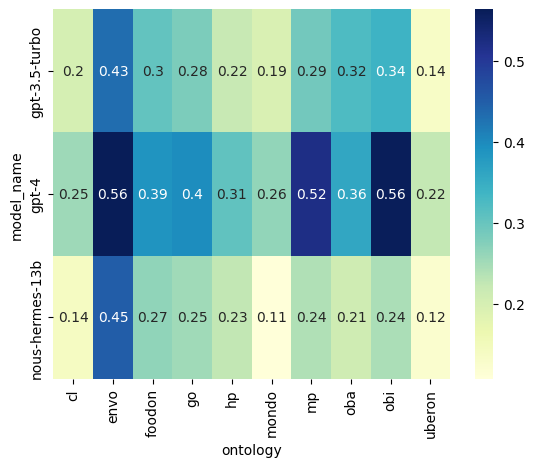

In [8]:
hm("relationships", "direct")

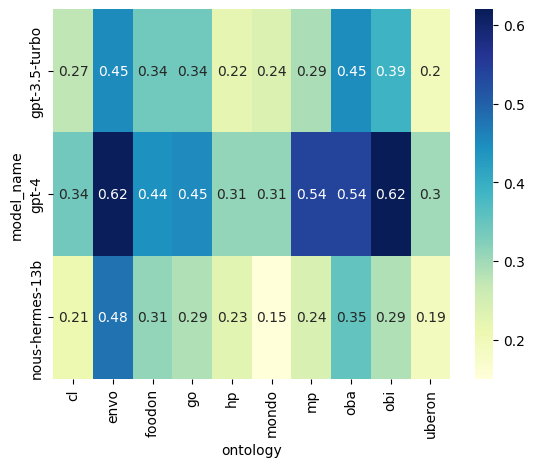

In [9]:
hm("relationships", "direct", metric="precision")

In [10]:
my_ttest("relationships", "direct")

gpt-4 v gpt-3.5-turbo: len 534 v len 490
gpt-4 v gpt-3.5-turbo: T-statistic: 4.112023238248865
gpt-4 v gpt-3.5-turbo: P-value: 4.236913758023157e-05
nous-hermes-13b v gpt-4: len 490 v len 534
nous-hermes-13b v gpt-4: T-statistic: -6.177142332114187
nous-hermes-13b v gpt-4: P-value: 9.40873856811828e-10
nous-hermes-13b v gpt-3.5-turbo: len 490 v len 490
nous-hermes-13b v gpt-3.5-turbo: T-statistic: -2.025803774325807
nous-hermes-13b v gpt-3.5-turbo: P-value: 0.04305599783078805


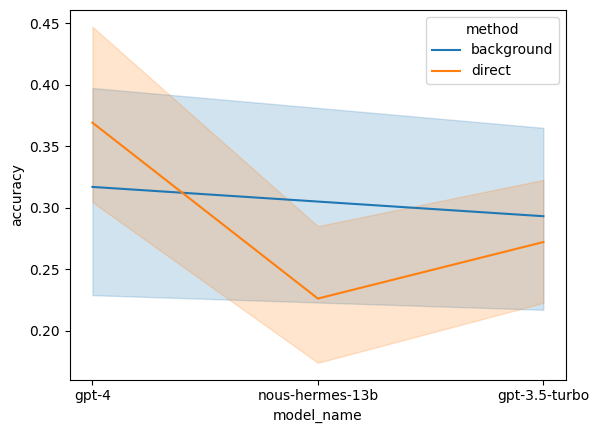

In [11]:
lp("relationships")

## Labels Task

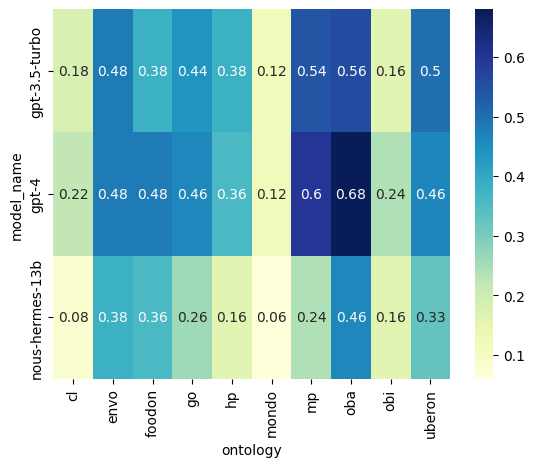

In [12]:
hm("label", "direct")

In [13]:
my_ttest("label", "direct")

nous-hermes-13b v gpt-3.5-turbo: len 490 v len 490
nous-hermes-13b v gpt-3.5-turbo: T-statistic: -4.250683289260626
nous-hermes-13b v gpt-3.5-turbo: P-value: 2.335200189764006e-05
nous-hermes-13b v gpt-4: len 490 v len 534
nous-hermes-13b v gpt-4: T-statistic: -5.742353921256174
nous-hermes-13b v gpt-4: P-value: 1.2305589278898132e-08
gpt-4 v gpt-3.5-turbo: len 534 v len 490
gpt-4 v gpt-3.5-turbo: T-statistic: 1.3882535138731187
gpt-4 v gpt-3.5-turbo: P-value: 0.16536238417228605


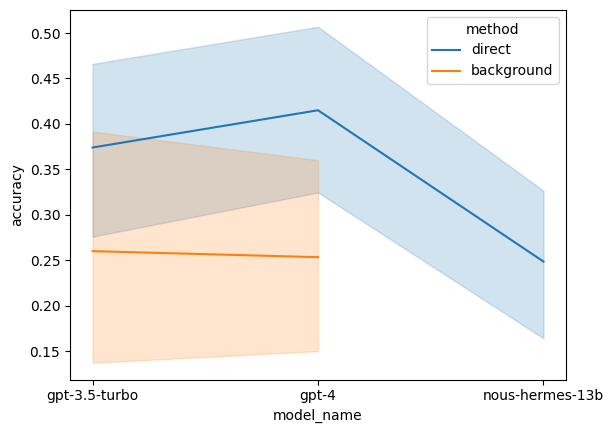

In [14]:
lp("label")

## Logical Definitions

In [15]:
import numpy as np

def load_ldef_results_tsv(f):
    res = pd.read_csv(f, comment="#", sep="\t")
    res['expected_logical_definition'].replace('', np.nan, inplace=True)
    res = res[res['expected_logical_definition'].notnull()]
    # Calculate Accuracy per row: (TP + TN) / (TP + TN + FP + FN)
    # Since we can't calculate TN here, we'll omit it from the formula
    res['accuracy'] = res['metric_true_positives'] / (res['metric_true_positives'] + res['metric_false_positives'] + res['metric_false_negatives'])
    res['precision'] = res['metric_true_positives'] / (res['metric_true_positives'] + res['metric_false_positives'])

    return res
    

res = load_ldef_results_tsv("results/ont_go-Plogical_definition-Mid.original_id-BGFalse-TrNone-Te50-Mgpt-4-EMopenai.results.tsv")
res.describe(include="all")

,id,label,definition,aliases,relationships,logical_definition,original_id,masked_id,feature_label,feature_definition,...,metric_recall,metric_f1_score,metric_accuracy,metric_specificity,metric_true_positives,metric_true_negatives,metric_false_positives,metric_false_negatives,accuracy,precision
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,15,15,...,15.000000,15.000000,15.000000,15.0,15.000000,15.0,15.000000,15.000000,15.000000,15.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,15,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CasparianStripAssembly,Casparian strip assembly,"The aggregation, arrangement and bonding toget...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.877778,0.877778,0.833333,0.0,1.866667,0.0,0.266667,0.266667,0.833333,0.877778
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.213313,0.213313,0.288675,0.0,0.516398,0.0,0.457738,0.457738,0.288675,0.213313
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.500000,0.500000,0.333333,0.0,1.000000,0.0,0.000000,0.000000,0.333333,0.500000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.833333,0.833333,0.750000,0.0,2.000000,0.0,0.000000,0.000000,0.750000,0.833333
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,1.000000,1.000000,0.0,2.000000,0.0,0.000000,0.000000,1.000000,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,1.000000,1.000000,0.0,2.000000,0.0,0.500000,0.500000,1.000000,1.000000


In [16]:
def load_all_results_ldefs():
    files = glob.glob("results/*.results.yaml")
    objs = []
    for f in files:
        obj = load_results(f)
        if obj["task"] != "logical_definition":
            continue
        accuracy = load_ldef_results_tsv(f.replace(".yaml", ".tsv"))["accuracy"].mean()
        obj["accuracy"] = accuracy
        objs.append(obj)
    return objs

objs = load_all_results_ldefs()

In [17]:
ldefs_df = pd.DataFrame(objs)

### Logical Definitions (Excluding terms with none)

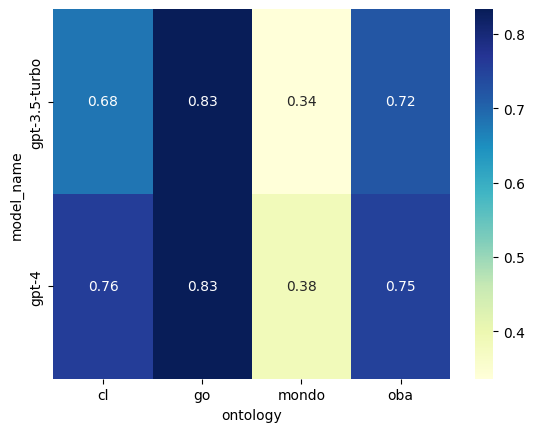

In [18]:
hm("logical_definition", "direct", ldefs_df)

### Logical Definitions (including over-prediction)

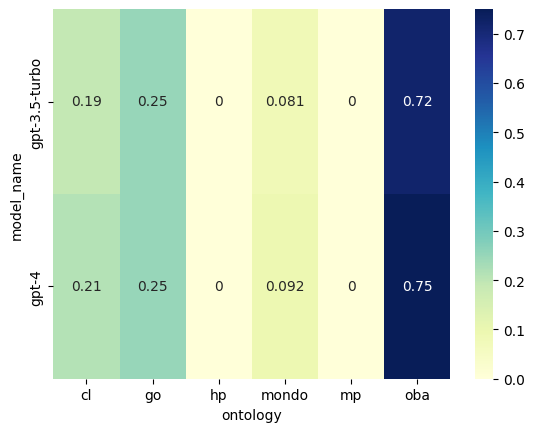

In [19]:
hm("logical_definition", "direct")

## Definitions Task

### Definitions (direct)

No additional background knowledge

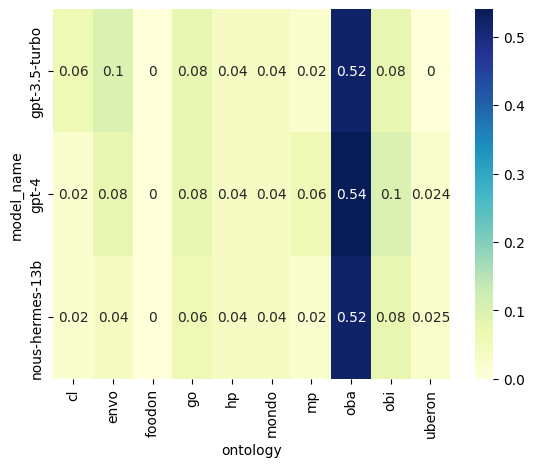

In [20]:
hm("definition", "direct")

In [21]:
my_ttest("definition", "direct")

nous-hermes-13b v gpt-4: len 490 v len 534
nous-hermes-13b v gpt-4: T-statistic: -0.4422687120609897
nous-hermes-13b v gpt-4: P-value: 0.6583883451314068
nous-hermes-13b v gpt-3.5-turbo: len 490 v len 490
nous-hermes-13b v gpt-3.5-turbo: T-statistic: -0.5553592957013923
nous-hermes-13b v gpt-3.5-turbo: P-value: 0.5787759324255379
gpt-4 v gpt-3.5-turbo: len 534 v len 490
gpt-4 v gpt-3.5-turbo: T-statistic: -0.12463371190328555
gpt-4 v gpt-3.5-turbo: P-value: 0.9008380476084143


### Definitions with github as background method

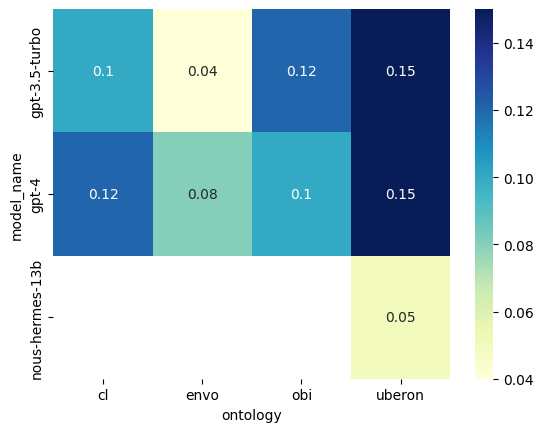

In [22]:
hm("definition", "github")

### Definitions with auto-generated background summaries

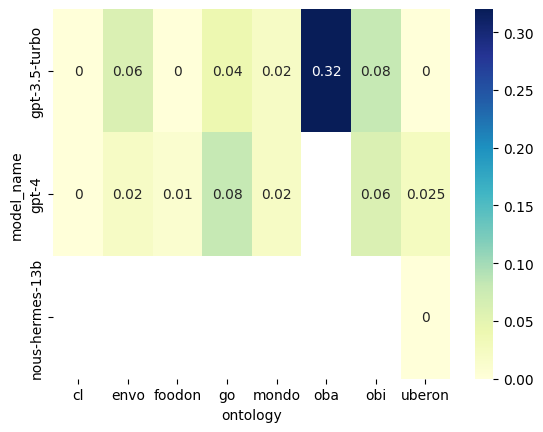

In [23]:
hm("definition", "background")

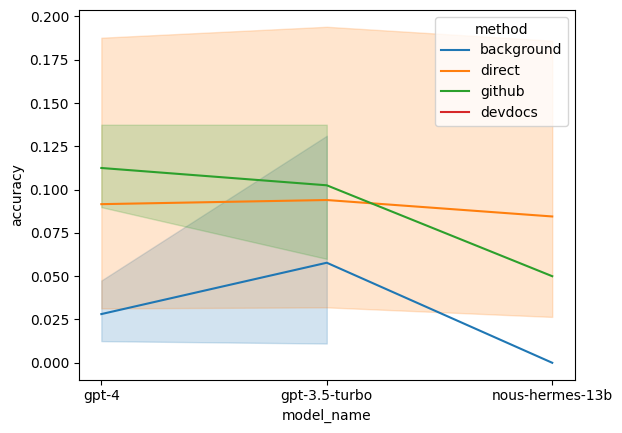

In [24]:
lp("definition")

### Definitions using developer docs

In [25]:
df.query("ontology == 'cl' and task == 'definition'")["method"].unique()

array(['background', 'github', 'direct', 'devdocs'], dtype=object)

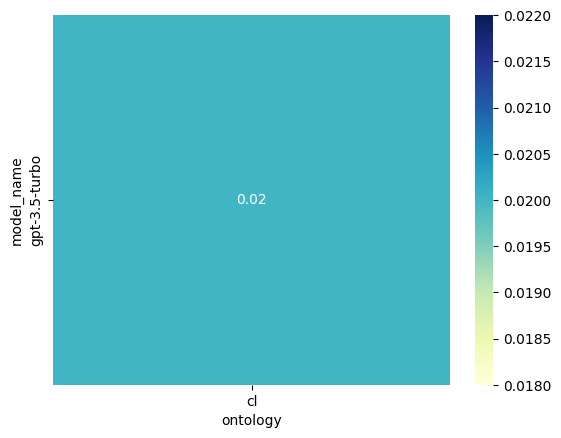

In [26]:
hm("definition", "devdocs", df.query("ontology == 'cl'"))

### Significance of different methods

In [27]:
methods = all_df["method"].unique()
models = all_df["model_name"].unique()
for m1 in methods:
    for m2 in methods:
        if m2 >= m1:
            continue
        for mn in list(models) + [None]:
            if mn is None:
                all_df_x = all_df.query("task == 'definition'")
            else:
                all_df_x = all_df.query(f"task == 'definition' and model_name == '{mn}'")
            m1_data = all_df_x[(all_df_x['method'] == m1)]['accuracy']
            m2_data = all_df_x[(all_df_x['method'] == m2)]['accuracy']

            # Step 2: Conduct the T-Test
            # Use ttest_ind to conduct the t-test
            t_statistic, p_value = stats.ttest_ind(m1_data, m2_data)

            print(f'{mn}:: {m1} v {m2}: T-statistic: {t_statistic}')
            print(f'{mn}:: {m1} v {m2}: P-value: {p_value}')


gpt-3.5-turbo:: direct v background: T-statistic: 2.0875438001560243
gpt-3.5-turbo:: direct v background: P-value: 0.03711127178139538
gpt-4:: direct v background: T-statistic: 3.9853780480912504
gpt-4:: direct v background: P-value: 7.269205811216471e-05
nous-hermes-13b:: direct v background: T-statistic: 1.9328344617694948
nous-hermes-13b:: direct v background: P-value: 0.05379100430828232
None:: direct v background: T-statistic: 4.446439014424472
None:: direct v background: P-value: 9.131095510584289e-06
gpt-3.5-turbo:: direct v devdocs: T-statistic: 1.7989544413644611
gpt-3.5-turbo:: direct v devdocs: P-value: 0.07258619973428591
gpt-4:: direct v devdocs: T-statistic: nan
gpt-4:: direct v devdocs: P-value: nan
nous-hermes-13b:: direct v devdocs: T-statistic: nan
nous-hermes-13b:: direct v devdocs: P-value: nan
None:: direct v devdocs: T-statistic: 1.7505665019530694
None:: direct v devdocs: P-value: 0.08021692093132692
gpt-3.5-turbo:: github v direct: T-statistic: 0.161092663060306

## Subsumption Analysis

Note that the relationships stats above are calculated on predicting *all* relationships.

To compare with owl2vec, we filter these for only subsumptions (subClassOf) relationships. See https://arxiv.org/pdf/2009.14654.pdf


In [28]:
import json

def subsumptions(rel_str: str):
    if pd.isnull(rel_str):
        return []
    if not isinstance(rel_str, str):
        print(f"BAD: {rel_str}")
        return []
    rels = yaml.safe_load(rel_str)
    for rel in rels:
         if "predicate" not in rel:
             print(f"BAD REL: {rel} in {rel_str}")
    return [r["target"] for r in rels if r.get("predicate", "") =="subClassOf"]

def calculate_metrics(row):
    expected_set = set(row['expected_subsumptions'])
    predicted_set = set(row['predicted_subsumptions'])
    
    TP = len(expected_set & predicted_set)
    FP = len(predicted_set - expected_set)
    FN = len(expected_set - predicted_set)
    
    # In a classical setting, TN would be calculated here. 
    # However, if you don't have information about what could have been predicted 
    # but wasn't (i.e., the universal set), TN can't be calculated.
    
    return pd.Series({'TP': TP, 'FP': FP, 'FN': FN})
    

def load_subsumption_results_tsv(f):
    res = pd.read_csv(f, comment="#", sep="\t")
    res['expected_subsumptions'] = res.apply(lambda row : subsumptions(row['expected_relationships']), axis = 1)
    res['predicted_subsumptions'] = res.apply(lambda row : subsumptions(row['predicted_relationships']), axis = 1)
    metrics_df = res.apply(calculate_metrics, axis=1)

    # Add the metrics as new columns to the original DataFrame
    df_with_metrics = pd.concat([df, metrics_df], axis=1)

    # Calculate Accuracy per row: (TP + TN) / (TP + TN + FP + FN)
    # Since we can't calculate TN here, we'll omit it from the formula
    df_with_metrics['accuracy'] = df_with_metrics['TP'] / (df_with_metrics['TP'] + df_with_metrics['FP'] + df_with_metrics['FN'])
    df_with_metrics['precision'] = df_with_metrics['TP'] / (df_with_metrics['TP'] + df_with_metrics['FP'])

    return df_with_metrics
    

res = load_subsumption_results_tsv("results/ont_uberon-Prelationships-Mid.original_id-BGFalse-TrNone-Te40-Mgpt-4-EMopenai.results.tsv")
res.describe(include="all")

,model_name,embedding_model_name,generate_background,task_started,task_finished,executed_on,agent,extractor,method,source_db_path,...,specificity,true_positives,true_negatives,false_positives,false_negatives,task,ontology,TP,FP,FN
count,159,159,159,159,159,159,159,159,159,159,...,159.0,159.000000,159.0,159.000000,159.000000,159,159,40.000000,40.000000,40.000000
unique,3,1,2,159,159,1,1,1,4,1,...,NaN,NaN,NaN,NaN,NaN,4,10,NaN,NaN,NaN
top,gpt-3.5-turbo,openai:,False,2023-09-04 13:31:12.160393,2023-09-04 13:32:28.413164,Darwin-21.6.0-Darwin Kernel Version 21.6.0: Mo...,dae,BasicExtractor,direct,db,...,NaN,NaN,NaN,NaN,NaN,definition,cl,NaN,NaN,NaN
freq,64,159,115,1,1,159,159,159,105,159,...,NaN,NaN,NaN,NaN,NaN,59,20,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,15.823899,0.0,43.654088,38.553459,NaN,NaN,0.300000,0.675000,0.950000
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,15.478664,0.0,19.602695,17.011034,NaN,NaN,0.464095,0.525625,0.714322
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.000000,0.0,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,3.000000,0.0,33.000000,29.000000,NaN,NaN,0.000000,0.000000,1.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,13.000000,0.0,42.000000,39.000000,NaN,NaN,0.000000,1.000000,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,26.000000,0.0,47.000000,47.000000,NaN,NaN,1.000000,1.000000,1.000000


In [29]:
import json

def subsumptions(rel_str: str):
    if pd.isnull(rel_str):
        return []
    if not isinstance(rel_str, str):
        print(f"BAD: {rel_str}")
        return []
    rels = yaml.safe_load(rel_str)
    for rel in rels:
         if "predicate" not in rel:
             print(f"BAD REL: {rel} in {rel_str}")
    return [r["target"] for r in rels if r.get("predicate", "") =="subClassOf"]

def calculate_metrics(row):
    expected_set = set(row['expected_subsumptions'])
    predicted_set = set(row['predicted_subsumptions'])
    
    TP = len(expected_set & predicted_set)
    FP = len(predicted_set - expected_set)
    FN = len(expected_set - predicted_set)
    
    # In a classical setting, TN would be calculated here. 
    # However, if you don't have information about what could have been predicted 
    # but wasn't (i.e., the universal set), TN can't be calculated.
    
    return pd.Series({'TP': TP, 'FP': FP, 'FN': FN})
    

def load_subsumption_results_tsv(f):
    res = pd.read_csv(f, comment="#", sep="\t")
    res['expected_subsumptions'] = res.apply(lambda row : subsumptions(row['expected_relationships']), axis = 1)
    res['predicted_subsumptions'] = res.apply(lambda row : subsumptions(row['predicted_relationships']), axis = 1)
    metrics_df = res.apply(calculate_metrics, axis=1)

    # Add the metrics as new columns to the original DataFrame
    df_with_metrics = pd.concat([df, metrics_df], axis=1)

    # Calculate Accuracy per row: (TP + TN) / (TP + TN + FP + FN)
    # Since we can't calculate TN here, we'll omit it from the formula
    df_with_metrics['accuracy'] = df_with_metrics['TP'] / (df_with_metrics['TP'] + df_with_metrics['FP'] + df_with_metrics['FN'])
    df_with_metrics['precision'] = df_with_metrics['TP'] / (df_with_metrics['TP'] + df_with_metrics['FP'])

    return df_with_metrics
    

#res = load_subsumption_results_tsv("results/ont_uberon-Prelationships-Mid.original_id-BGFalse-TrNone-Te40-Mgpt-4-EMopenai.results.tsv")
#res.describe(include="all")

,model_name,embedding_model_name,generate_background,task_started,task_finished,executed_on,agent,extractor,method,source_db_path,...,specificity,true_positives,true_negatives,false_positives,false_negatives,task,ontology,TP,FP,FN
count,159,159,159,159,159,159,159,159,159,159,...,159.0,159.000000,159.0,159.000000,159.000000,159,159,40.000000,40.000000,40.000000
unique,3,1,2,159,159,1,1,1,4,1,...,NaN,NaN,NaN,NaN,NaN,4,10,NaN,NaN,NaN
top,gpt-3.5-turbo,openai:,False,2023-09-04 13:31:12.160393,2023-09-04 13:32:28.413164,Darwin-21.6.0-Darwin Kernel Version 21.6.0: Mo...,dae,BasicExtractor,direct,db,...,NaN,NaN,NaN,NaN,NaN,definition,cl,NaN,NaN,NaN
freq,64,159,115,1,1,159,159,159,105,159,...,NaN,NaN,NaN,NaN,NaN,59,20,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,15.823899,0.0,43.654088,38.553459,NaN,NaN,0.300000,0.675000,0.950000
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,15.478664,0.0,19.602695,17.011034,NaN,NaN,0.464095,0.525625,0.714322
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.000000,0.0,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,3.000000,0.0,33.000000,29.000000,NaN,NaN,0.000000,0.000000,1.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,13.000000,0.0,42.000000,39.000000,NaN,NaN,0.000000,1.000000,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,26.000000,0.0,47.000000,47.000000,NaN,NaN,1.000000,1.000000,1.000000


In [30]:
res["accuracy"].mean()

0.25

In [31]:
def load_all_results_subsumptions():
    files = glob.glob("results/*.results.yaml")
    objs = []
    for f in files:
        obj = load_results(f)
        if obj["task"] != "relationships":
            continue
        accuracy = load_subsumption_results_tsv(f.replace(".yaml", ".tsv"))["accuracy"].mean()
        obj["accuracy"] = accuracy
        objs.append(obj)
    return objs

objs = load_all_results_subsumptions()

BAD REL: {'predictive': 'subClassOf', 'target': 'TransitionalEpithelialCell'} in [{'predicate': 'PartOf', 'target': 'Urothelium'}, {'predictive': 'subClassOf', 'target': 'TransitionalEpithelialCell'}]
BAD REL: {'predictor': 'hasCausalAgent', 'effect': 'increased hunger, malnutrition and consequent mortality'} in [{'predicate': 'subClassOf', 'target': 'AnthropogenicEnvironmentalProcess'}, {'predictor': 'hasCausalAgent', 'effect': 'increased hunger, malnutrition and consequent mortality'}]
BAD REL: {'predictive': 'subClassOf', 'target': 'Iris'} in [{'predicate': 'PartOf', 'target': 'CameraTypeEye'}, {'predictive': 'subClassOf', 'target': 'Iris'}]


### Main subsumption results

In [32]:
subs_df = pd.DataFrame(objs)

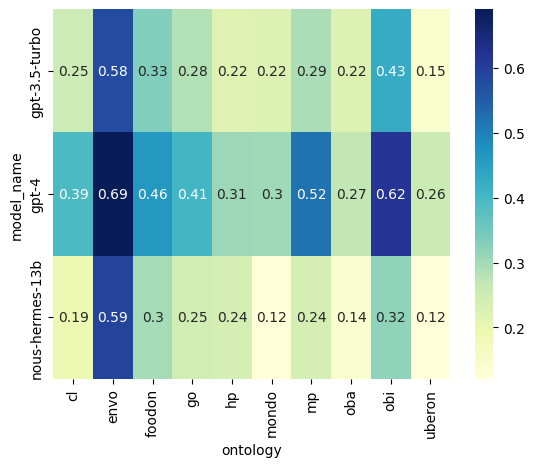

In [33]:
hm("relationships", "direct", subs_df)

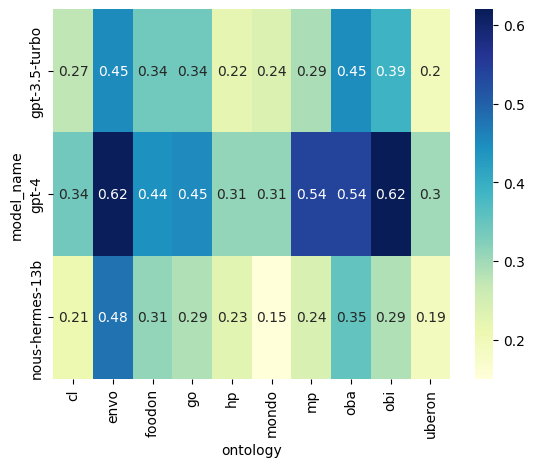

In [34]:
hm("relationships", "direct", subs_df, metric="precision")

### Subsumptions using background

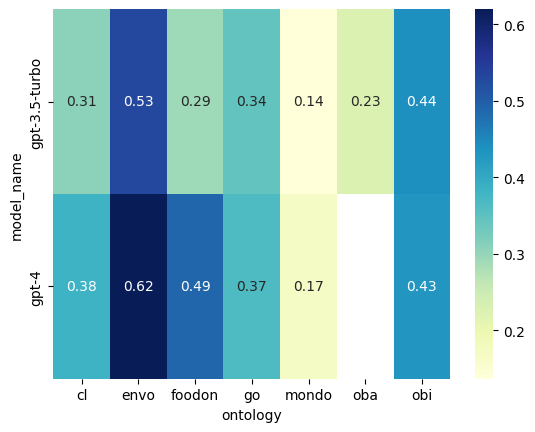

In [35]:
hm("relationships", "background", subs_df)

### Subsumptions using github

In [36]:
#hm("relationships", "github", subs_df)

## Preparing definitions for evaluation

In [37]:
defs_df = all_df.query("task == 'definition'")
defs_df.groupby('ontology').size().reset_index(name='count')

,ontology,count
0,cl,400
1,envo,350
2,foodon,350
3,go,250
4,hp,150
5,mondo,250
6,mp,150
7,oba,200
8,obi,350
9,uberon,404


In [38]:
len(defs_df)

2854

In [39]:
len(defs_df["expected_definition"].unique())

437

In [40]:

df_defs_gpt_direct = pd.read_csv("results/cl-defs-direct.tsv", sep="\t")
gpt_direct = { row["id"]: row["definition"] for _, row in df_defs_gpt_direct.iterrows() }
objs = []
for _, row in defs_df.iterrows():
    id = row["masked_original_id"]
    if id not in gpt_direct:
        continue
    row = {**row}
    row["predicted_definition"] = gpt_direct[id]
    row["model_name"] = "gpt-4"
    row["method"] = "no_RAG"
    del gpt_direct[id]
    objs.append(row)
all_defs_df = pd.concat([defs_df, pd.DataFrame(objs)])
all_defs_df

,masked_id,expected_label,feature_definition,feature_aliases,feature_relationships,feature_logical_definition,masked_original_id,predicted_label,metric_precision,metric_recall,...,predicted_definition,id,label,definition,aliases,relationships,logical_definition,original_id,expected_logical_definition,predicted_logical_definition
0,PignutHickoryNut,NaN,NaN,NaN,"[{'predicate': 'InTaxon', 'target': 'CaryaGlab...","[{'predicate': 'rdfs:subClassOf', 'target': 'C...",FOODON:00004448,NaN,0.0,0.0,...,A caryopsis fruit of a pignut hickory tree (Ca...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GreekYogurt,NaN,NaN,NaN,"[{'predicate': 'subClassOf', 'target': 'Strain...",NaN,FOODON:00004409,NaN,0.0,0.0,...,Greek yogurt is a type of yogurt that is made ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TurkeyMeat_ground_sauteed_,NaN,NaN,NaN,"[{'predicate': 'subClassOf', 'target': 'Turkey...",NaN,FOODON:00004417,NaN,0.0,0.0,...,Ground sautéed turkey meat is a specific type ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Raw,NaN,NaN,NaN,"[{'predicate': 'subClassOf', 'target': 'FoodOb...",NaN,FOODON:00004348,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SpeltFoodProduct,NaN,NaN,NaN,"[{'predicate': 'subClassOf', 'target': 'WheatF...",NaN,FOODON:00004434,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,IntermediateCellOfUrothelium,NaN,NaN,NaN,"[{'predicate': 'subClassOf', 'target': 'Urothe...",NaN,CL:4030055,NaN,0.0,0.0,...,An intermediate cell of urothelium is a transi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,LungPerichondrialFibroblast,NaN,NaN,NaN,"[{'predicate': 'subClassOf', 'target': 'Fibrob...","[{'predicate': 'rdfs:subClassOf', 'target': 'P...",CL:4033026,NaN,0.0,0.0,...,A lung perichondrial fibroblast is a type of f...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,DiffuseBipolar1Cell,NaN,NaN,NaN,"[{'predicate': 'subClassOf', 'target': 'OFFBip...",NaN,CL:4033027,NaN,0.0,0.0,...,The diffuse bipolar 1 cell is a specialized ty...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,ChorionicGirdleCell,NaN,NaN,NaN,"[{'predicate': 'subClassOf', 'target': 'Chorio...",NaN,CL:4040001,NaN,0.0,0.0,...,A chorionic girdle cell is a specialized type ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
